In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
import pickle

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import xgboost

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict

%matplotlib inline

In [2]:
# read in data from csv file
df = pd.read_csv('proteins-5-functions.csv')

df.head()

,classification,name,sequence,structureId,type
0,TRANSFERASE,NaN,MEIYEGKLTAEGLRFGIVASRFNHALVDRLVEGAIDCIVRHGGREE...,5MPP,4
1,HYDROLASE,NaN,MKFTLTIAGLLAVGSTAAPTTEKRNPGGIDYVQNYNGDVADFQYNE...,3M4F,0
2,TRANSFERASE,NaN,MRGSHHHHHHGSMKRAVITGLGIVSSIGNNQQEVLASLREGRSGIT...,2BYY,4
3,HYDROLASE,NaN,STGSATTTPIDSLDDAYITPVQIGTPAQTLNLDFDTGSSDLWVFSS...,4YCY,0
4,TRANSFERASE,NaN,GSGMMRYLHKIELELNRLTSRYPFFKKIAFDAEIIKLVDDLNVDEN...,3AQC,4


In [3]:
# read in more immune system sequences data from csv file
df_2 = pd.read_csv('uniprot-human-immune.csv')

df_2.head()

,name,sequence,classification,type
0,tr|Q6FGW4|Q6FGW4_HUMAN,MHSSALLCCLVLLTGVRASPGQGTQSENSCTHFPGNLPNMLRDLRD...,IMMUNE SYSTEM,1
1,tr|A0A024R5Z3|A0A024R5Z3_HUMAN,MSSILPFTPPIVKRLLGWKKGEQNGQEEKWCEKAVKSLVKKLKKTG...,IMMUNE SYSTEM,1
2,tr|A0A0B4Q6D0|A0A0B4Q6D0_9PLVG,MRVKGIRKNYQHLWRGGTLLLGMLMICSAVEKLWVTVYYGVPVWKE...,IMMUNE SYSTEM,1
3,tr|A0A0B4Q7W6|A0A0B4Q7W6_9PLVG,MRVKGIRKNYQHLWRGGTLLLGMLMICSAVEKLWVTVYYGVPVWKE...,IMMUNE SYSTEM,1
4,tr|A0A0B4Q6H6|A0A0B4Q6H6_9PLVG,MRVKGIRKNYQHLWRGGTLLLGMLMICSAVEKLWVTVHYGVPVWKE...,IMMUNE SYSTEM,1


In [4]:
df_2.shape

(84798, 4)

In [5]:
df3 = df_2.sample(frac=0.33)
df3.shape

(27983, 4)

In [6]:
df_hydro = pd.read_csv('uniprot-hydrolase-reviewed.csv')

df_hydro.head()

,name,sequence,classification,type
0,sp|P9WNH5|HSAD_MYCTU,MTATEELTFESTSRFAEVDVDGPLKLHYHEAGVGNDQTVVLLHGGG...,HYDROLASE,0
1,sp|P77044|MHPC_ECOLI,MSYQPQTEAATSRFLNVEEAGKTLRIHFNDCGQGDETVVLLHGSGP...,HYDROLASE,0
2,sp|Q75UV1|NDX1_THETH,MELGAGGVVFNAKREVLLLRDRMGFWVFPKGHPEPGESLEEAAVRE...,HYDROLASE,0
3,sp|Q60928|GGT1_MOUSE,MKNRFLVLGLVAVVLVFVIIGLCIWLPYTSGKPDHVYSRAAVATDA...,HYDROLASE,0
4,sp|P19440|GGT1_HUMAN,MKKKLVVLGLLAVVLVLVIVGLCLWLPSASKEPDNHVYTRAAVAAD...,HYDROLASE,0


In [7]:
df_h2 = df_hydro.sample(frac=0.45)
df_h2.shape

(26386, 4)

In [8]:
df_ox = pd.read_csv('uniprot-oxidoreductase-Feb1.csv')

df_ox.head()

,name,sequence,classification,type
0,sp|Q8L540|LTO1_ARATH,MMARFVSVSSCQFHFGFREVSPPSVTSYPRRFEVSDRRFPAIPIKC...,OXIDOREDUCTASE,5
1,sp|Q9AL95|NROR_CLOAB,MKSTKILILGAGPAGFSAAKAALGKCDDITMINSEKYLPYYRPRLN...,OXIDOREDUCTASE,5
2,sp|P55931|ETFD_PIG,MMVPLAKLASPAYQCFHALKIKKNYLPLCATRWSSTCKVPRITTHY...,OXIDOREDUCTASE,5
3,sp|Q16134|ETFD_HUMAN,MLVPLAKLSCLAYQCFHALKIKKNYLPLCATRWSSTSTVPRITTHY...,OXIDOREDUCTASE,5
4,sp|Q9NZC7|WWOX_HUMAN,MAALRYAGLDDTDSEDELPPGWEERTTKDGWVYYANHTEEKTQWEH...,OXIDOREDUCTASE,5


In [9]:
df_FeS = pd.read_csv('uniprot-ironSulfurCluster-Feb1.csv')

df_FeS.head()

,name,sequence,classification,type
0,tr|T0M7Z9|T0M7Z9_CAMFR,MAAVVAFSLRRRFPATTLGGACLQQPWLALQDSLARCVKPTGRDCK...,IRON-SULFUR-CLUSTER,6
1,tr|A0A1Q9C7M1|A0A1Q9C7M1_SYMMI,MSLAASLRSLAPRGLGRSGLRGFAAMAQPQTFAIYRYDPDQQAKPF...,IRON-SULFUR-CLUSTER,6
2,tr|A0A2P6TTG2|A0A2P6TTG2_CHLSO,MLSLIRQAGSLGQALCPELTQLVRTVASAAGAAGGASKPVVEKEFL...,IRON-SULFUR-CLUSTER,6
3,tr|A0A091CKG8|A0A091CKG8_FUKDA,MAAVAGFSLRRRFPATVLGGSCLQACRGAQTAADRAPRIKKFAIYR...,IRON-SULFUR-CLUSTER,6
4,tr|Q59QN7|Q59QN7_CANAL,MFRSILHQQKAVQFSVRSLATAAAEKAPRLKKFQIYRWNPDTPEVQ...,IRON-SULFUR-CLUSTER,6


In [10]:
df_gpcr = pd.read_csv('uniprot-gpcr-unreviewed.csv')

df_gpcr.head()

,name,sequence,classification,type
0,tr|G3V654|G3V654_RAT,MAATTPAQDVGVEIYLGPVWPAPSNSTPLALNLSLALREDAPGNLT...,GPCR,8
1,tr|A0A287DFW8|A0A287DFW8_ICTTR,MDVTSPAHTFGMEIYPRTTQLADSNSTSPELNLSLPLQGTALVNQT...,GPCR,8
2,tr|A0A0R4J0N8|A0A0R4J0N8_MOUSE,MEPISVSIYTSDNYSEEVGSGDYDSNKEPCFRDENVHFNRIFLPTI...,GPCR,8
3,tr|A0A1U7QAF5|A0A1U7QAF5_MESAU,MDPLNLSWYDDDLERQNWSRPFNGSEGKADRPHYNYYAMLLTLLIF...,GPCR,8
4,tr|A0A0N8ETT2|A0A0N8ETT2_HETGA,MDPLNLTWYDDDLERQNWSRSFNGSEGKADRPHYNYYAMLLTLLIF...,GPCR,8


In [11]:
df_gp2 = df_gpcr.sample(frac=0.16)

df_gp2.shape

(31401, 4)

In [12]:
df_lb = pd.read_csv('uniprot-lipidBinding-Feb5.csv')
df_lb2 = df_lb.sample(frac=0.5)

df_lb2.shape

(31304, 4)

In [13]:
df_tr = pd.read_csv('uniprot-transport-Feb6.csv')
df_tr2 = df_tr.sample(frac=0.75)

df_tr2.shape

(47019, 4)

In [14]:
df_abc = pd.read_csv('uniprot-ABC-Feb8.csv')

df_abc.shape

(3642, 4)

In [15]:
df_dna = pd.read_csv('uniprot-DNA-Binding-Feb8.csv')

df_dna.shape

(60440, 4)

In [16]:
df.columns

Index([u'classification', u'name', u'sequence', u'structureId', u'type'], dtype='object')

In [17]:
df.shape

(104956, 5)

In [18]:
# concat the dataframes
df_ = pd.concat([df,df3,df_h2,df_ox,df_FeS,df_gp2,df_lb2,df_tr2,df_abc,df_dna])

df_.head()

/Users/scottlew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,classification,name,sequence,structureId,type
0,TRANSFERASE,NaN,MEIYEGKLTAEGLRFGIVASRFNHALVDRLVEGAIDCIVRHGGREE...,5MPP,4
1,HYDROLASE,NaN,MKFTLTIAGLLAVGSTAAPTTEKRNPGGIDYVQNYNGDVADFQYNE...,3M4F,0
2,TRANSFERASE,NaN,MRGSHHHHHHGSMKRAVITGLGIVSSIGNNQQEVLASLREGRSGIT...,2BYY,4
3,HYDROLASE,NaN,STGSATTTPIDSLDDAYITPVQIGTPAQTLNLDFDTGSSDLWVFSS...,4YCY,0
4,TRANSFERASE,NaN,GSGMMRYLHKIELELNRLTSRYPFFKKIAFDAEIIKLVDDLNVDEN...,3AQC,4


In [19]:
df_.shape

(404127, 5)

In [20]:
# remove the duplicate protein sequences
df2 = df_.drop_duplicates(subset='sequence', keep="first")

df2.shape

(380114, 5)

In [21]:
hydro_seq = df2[df2.classification == 'HYDROLASE'].sequence.reset_index(drop=True)
                
dna_seq = df2[df2.classification == 'DNA BINDING'].sequence.reset_index(drop=True)

In [22]:
print(len(hydro_seq))
print
print(len(dna_seq))

37467

53003


In [23]:
hydro2 = hydro_seq.sample(n=100, random_state=1)
hydro2[0:3]

541      IVGGEDAKPGQFPWQVVLNGKVDAFCGGSIVNEKWIVTAAHCVETG...
30662    MLLRGIPAAEKILQRLKEEISQSPTSPGLAVVLIGNDPASEVYVGM...
29080    MKFVDEALIKVEAGKGGNGCLSFRREKFIPRGGPDGGDGGDGGSIY...
Name: sequence, dtype: object

In [24]:
#hydro_seq[9]

In [25]:
%%time

ratios = []
max_scores = []
for seq1 in hydro2:
    scores = []
    for seq2 in dna_seq:
        scores.append(fuzz.ratio(seq1,seq2))
        ratios.append(fuzz.ratio(seq1,seq2))
    max_scores.append(max(scores))
    
print('*********************')
print
print('Done!')
print


*********************

Done!

CPU times: user 1h 45min 9s, sys: 1min, total: 1h 46min 10s
Wall time: 2h 16min 38s


In [26]:
print(len(max_scores))

100


In [27]:
max_scores

[49,
 41,
 45,
 45,
 42,
 39,
 42,
 93,
 42,
 88,
 41,
 42,
 50,
 45,
 91,
 83,
 52,
 73,
 47,
 58,
 40,
 40,
 49,
 61,
 41,
 39,
 43,
 42,
 40,
 41,
 42,
 40,
 76,
 90,
 39,
 41,
 41,
 43,
 41,
 42,
 39,
 40,
 43,
 40,
 42,
 47,
 46,
 42,
 51,
 41,
 41,
 41,
 39,
 41,
 40,
 40,
 70,
 99,
 40,
 76,
 58,
 39,
 43,
 46,
 41,
 40,
 41,
 92,
 40,
 42,
 91,
 42,
 50,
 40,
 41,
 65,
 56,
 43,
 88,
 42,
 40,
 40,
 44,
 43,
 47,
 40,
 48,
 41,
 39,
 72,
 40,
 40,
 41,
 54,
 40,
 95,
 41,
 39,
 50,
 40]

In [28]:
print(len(scores))

53003


In [29]:
print(len(ratios))

5300300


In [30]:
print(max(max_scores))
print
print(np.mean(max_scores))

99

49.71


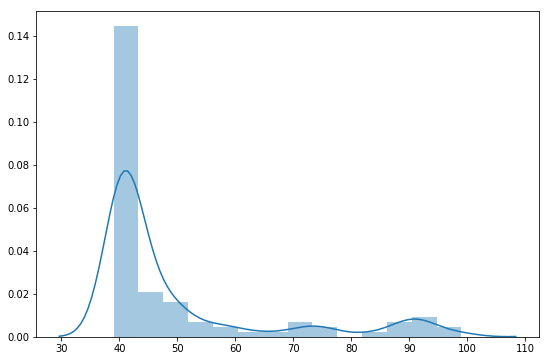

In [31]:
plt.figure(figsize = [9,6])
sns.distplot(max_scores)

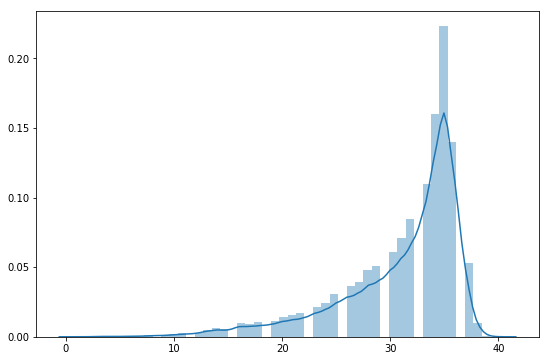

In [32]:
plt.figure(figsize = [9,6])
sns.distplot(scores)

In [33]:
print(max(scores))

40


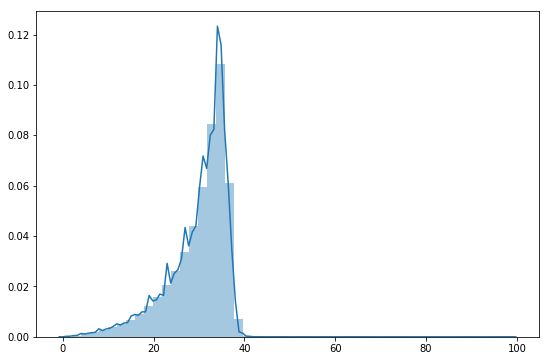

In [34]:
plt.figure(figsize = [9,6])
sns.distplot(ratios)

In [35]:
print(np.mean(ratios))

29.775405165745337


In [36]:
print(max(ratios))

99
